In [22]:
import pandas as pd
import numpy as np
import progressbar
import matplotlib.pyplot as plt
from IMPORT_DATAFRAME_JSON_HDF5 import *
%matplotlib notebook
import os

# Analysis of HDF5 files

Abtastfrequenz der HDF5 Dateien: 432080/(24*60*60)s = 5 1/s ---> 1 Wert representiert 0.2 Sekunden

### Umwandlung in minütliche Auflösung

# Import von allen 3 Phasen + Allen transienten

In [43]:
date = '2017-08-07'

In [44]:
Phase_1 = pd.read_hdf('HDF5/phase_1_' + date + '.h5', usecols=['P'])
Phase_2 = pd.read_hdf('HDF5/phase_2_' + date + '.h5', usecols=['P'])
Phase_3 = pd.read_hdf('HDF5/phase_3_' + date + '.h5', usecols=['P'])

In [25]:
# Alle transienten aus pkl

In [26]:
transients_1_phase = pd.read_pickle("transients_1_phase.pkl")
transients_2_phase =  pd.read_pickle("transients_2_phase.pkl")
transients_3_phase =  pd.read_pickle("transients_3_phase.pkl")
#events_from_outside =  pd.read_pickle("events_from_outside.pkl")
transients_all = pd.concat([transients_1_phase,transients_2_phase,transients_3_phase])


In [27]:
# Transienten vom 03-03 ohne split

In [28]:
data = import_trasient_from_file("jsons/")
data = map_transients_to_PQ_data(data, "HDF5", 20, ['P'])
# A unique index is needed in order to assign the new features to each unique transient
data['unique_index'] = range(1, len(data) + 1)
data = data.reset_index()
data = data.set_index('unique_index')


data['charging_status']=0
data['P_mean']=0
data['P_delta'] = 0
data['P_Plugin']=0
data['P_Unplug'] = 0
data['P_Before'] = 0
for row in range(0, len(data)):
    # Getting the mean power before during and after the timestamp (-T, T)
    # Defining charging_status as 1 for avg(P)>300W else 0 and writing it to a new column
    P_mean = sum(data.iloc[row]['P']) / float(len(data.iloc[row]['P']))
    data.set_value(data.index[row],'P_mean', P_mean)
    if P_mean>300:
        data.set_value(data.index[row],'charging_status',int(1))
    else:
       data.set_value(data.index[row],'charging_status', int(0))
     # Defining if a new car is plugged in during the appearance of the transient
    P_mean_before = sum((data.iloc[row]['P'])[:10]) / float(len((data.iloc[row]['P'])[:10])) 
    
    P_mean_after = sum((data.iloc[row]['P'])[(len(data.iloc[row]['P'])-10):]) / float(len((data.iloc[row]['P'])[(len(data.iloc[row]['P'])-10):])) 
    P_delta = P_mean_after - P_mean_before
    data.set_value(data.index[row],'P_delta',P_delta)
    data.set_value(data.index[row],'P_Before',P_mean_before)
    if P_delta > 2000:
        data.set_value(data.index[row],'P_Plugin',int(1))
    else:
        data.set_value(data.index[row],'P_Plugin',int(0))
    if P_delta < -2000:
        data.set_value(data.index[row],'P_Unplug',int(1))
    else:
        data.set_value(data.index[row],'P_Unplug',int(0))
        

#resetting index to begin_timestamp_float
data = data.set_index('begin_timestamp_float')

100% (67 of 67) |#########################| Elapsed Time: 0:00:02 Time: 0:00:02
100% (93 of 93) |#########################| Elapsed Time: 0:00:20 Time: 0:00:20


In [29]:
transients_new_import = data
print (len(transients_new_import))
print (len(transients_all))



93
492


Filtern aller transienten nach transienten vom 03_03

In [30]:
start = Phase_1.iloc[0]['timestamp']
end = Phase_1.iloc[len(Phase_1)-1]['timestamp']
print (str(start)+'       '+str(end))
print(end-start)

1502056800.04       1502143199.99
86399.9503548


In [31]:
transients_03_03 = transients_new_import.loc[(transients_new_import.index >= start) & (transients_new_import.index <= end)]
transients_all_03_03 = transients_all.loc[(transients_all.index >= start) & (transients_all.index <= end)]
transients_03_03 = transients_03_03.loc[transients_03_03['P_Plugin'] == 1]
print (len(transients_03_03))
print (len(transients_all_03_03))

6
0


#### Plot Leistung volle Auflösung (5 1/s --> 432000 Datenpunkte)

<IPython.core.display.Javascript object>


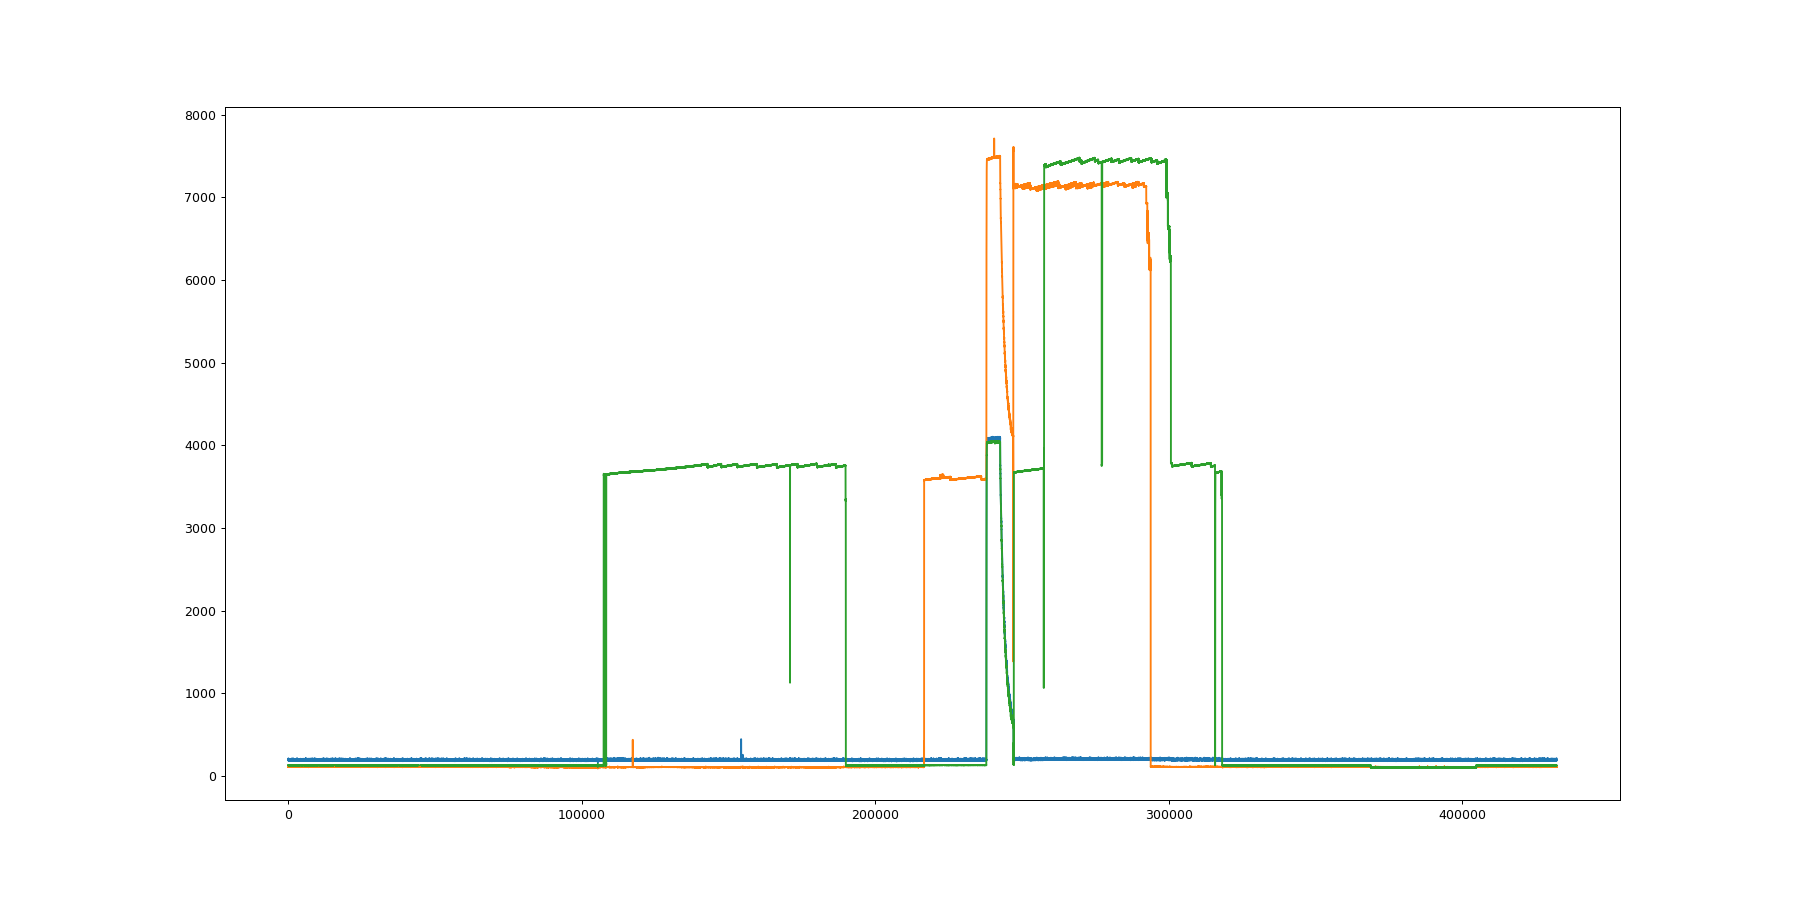

In [32]:
plt.figure(figsize=(20,10))
plt.plot(Phase_1['P'])
plt.plot(Phase_2['P'])
plt.plot(Phase_3['P'])

#### Plot in minütlicher Auflösung

In [33]:
Phase_1.index//2
Phase_2.index//2
Phase_3.index//2
Phase_1 = Phase_1.groupby(np.arange(len(Phase_1))//300).mean()
Phase_2 = Phase_2.groupby(np.arange(len(Phase_2))//300).mean()
Phase_3 = Phase_3.groupby(np.arange(len(Phase_3))//300).mean()

<IPython.core.display.Javascript object>


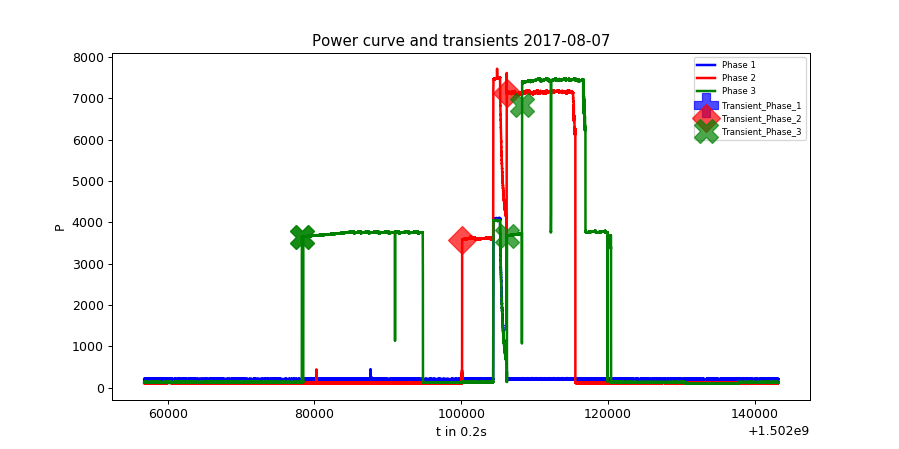

In [47]:
plt.figure(figsize=(10,5))
plt.plot(Phase_1['timestamp'],Phase_1['P'], color="blue", linewidth=2, label='Phase 1')
plt.plot(Phase_2['timestamp'],Phase_2['P'], color="red", linewidth=2, label='Phase 2')
plt.plot(Phase_3['timestamp'],Phase_3['P'], color="green", linewidth=2, label='Phase 3')
plt.plot((transients_03_03.loc[transients_03_03['phase_num'] == 1]).index,((transients_03_03.loc[transients_03_03['phase_num'] == 1])['P_delta']+(transients_03_03.loc[transients_03_03['phase_num'] == 1])['P_Before']), "P", color="blue", markersize=20,alpha=.7,label='Transient_Phase_1')
plt.plot((transients_03_03.loc[transients_03_03['phase_num'] == 2]).index,((transients_03_03.loc[transients_03_03['phase_num'] == 2])['P_delta']+(transients_03_03.loc[transients_03_03['phase_num'] == 2])['P_Before']), "D", color="red", markersize=16,alpha=.7,label='Transient_Phase_2')
plt.plot((transients_03_03.loc[transients_03_03['phase_num'] == 3]).index,((transients_03_03.loc[transients_03_03['phase_num'] == 3])['P_delta']+(transients_03_03.loc[transients_03_03['phase_num'] == 3])['P_Before']), "X", color="green", markersize=20,alpha=.7, label='Transient_Phase_3')
plt.legend(loc='upper right', frameon=True, fontsize = 'x-small')
plt.title('Power curve and transients ' + date)
plt.ylabel('P')
plt.xlabel('t in 0.2s')

In [35]:
transients_1_phase = transients_1_phase.loc[(transients_1_phase.index >= start) & (transients_1_phase.index <= end)]
transients_2_phase = transients_2_phase.loc[(transients_2_phase.index >= start) & (transients_2_phase.index <= end)]
transients_3_phase = transients_3_phase.loc[(transients_3_phase.index >= start) & (transients_3_phase.index <= end)]

In [36]:
print ('Eine:' + str(len(transients_1_phase)))
print ('Zwei:' + str(len(transients_2_phase)))
print ('Drei:' + str(len(transients_3_phase)))

Eine:0
Zwei:0
Drei:0


In [37]:
transients_2_phase

,begin_index,begin_timestamp_string,filtered_signal,phase_num,raw_signal_current,raw_signal_voltage,three_first_peaks,three_first_peaks_index,transient_rise_gradient,P,charging_status,P_mean,P_delta,P_Plugin,P_Unplug


In [38]:
transients_03_03

,begin_index,begin_timestamp_string,filtered_signal,phase_num,raw_signal_current,raw_signal_voltage,three_first_peaks,three_first_peaks_index,transient_rise_gradient,P,charging_status,P_mean,P_delta,P_Plugin,P_Unplug,P_Before
begin_timestamp_float,,,,,,,,,,,,,,,,
1.502078e+09,9566,07-08-2017_05:57:55_372503,"[0.0509015881, 0.0373594649, -0.2846501172, -0...",3,"[0.8697509766, 0.8850097656, 0.9002685547, 0.9...","[-296.6898498535, -296.6764221191, -296.461700...","[62.907, 18.293, 11.532]","[9579, 9593, 9643]",-2.386365e+06,"[131.18516540527344, 131.65499877929688, 131.2...",1,1352,3506,1,0,131
1.502078e+09,258,07-08-2017_05:57:55_373871,"[0.4357594913, 0.4344563004, 0.4490676893, 0.3...",3,"[0.9613037109, 0.9307861328, 0.9307861328, 0.9...","[-296.9448547363, -296.8240661621, -296.689849...","[33.856, 17.374, 11.446]","[272, 288, 748]",-1.183857e+06,"[131.18516540527344, 131.65499877929688, 131.2...",1,1352,3506,1,0,131
1.502100e+09,6137,07-08-2017_12:01:44_039193,"[-0.057616848500000005, -0.018337043, 0.046237...",2,"[0.6408691406, 0.5798339844, 0.5798339844, 0.5...","[296.7061462402, 296.7450866699, 296.745086669...","[66.969, 18.813, 3.624]","[6150, 6736, 7487]",-2.568434e+06,"[108.73812866210938, 108.79946899414062, 109.0...",1,1323,3470,1,0,108
1.502106e+09,6739,07-08-2017_13:43:04_156300,"[-0.3466140749, -0.2428589095, 0.0166519476, 0...",2,"[-21.7590332031, -21.8200683594, -21.896362304...","[-296.4077148438, -296.4466247559, -296.498535...","[40.189, 22.529, 16.292]","[6749, 6815, 7299]",2.011318e+06,"[4109.0966796875, 4099.7197265625, 4113.611328...",1,5169,3002,1,0,4116
1.502106e+09,5603,07-08-2017_13:43:33_865098,"[-0.1164327933, 0.08589934540000001, 0.0448971...",3,"[-0.9765625, -0.9765625, -0.9460449219, -1.022...","[296.877746582, 296.7032775879, 296.5288085938...","[36.792, 15.375, 10.924]","[5617, 5630, 5650]",-1.298789e+06,"[591.2913208007812, 590.1234130859375, 587.818...",1,1442,3071,1,0,598
1.502108e+09,4530,07-08-2017_14:17:44_464357,"[0.38919329010000003, 0.5099818687000001, 0.46...",3,"[-15.0604248047, -14.9993896484, -15.029907226...","[-297.6695556641, -297.6024475098, -297.401153...","[61.453, 17.662, 30.519]","[4539, 4573, 5415]",3.309675e+06,"[3719.640380859375, 3721.78662109375, 3721.661...",1,3827,3121,1,0,3720
